In [13]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers.linear import sinkhorn

In [2]:
rngs = jax.random.split(jax.random.PRNGKey(0), 2)
d, n_x, n_y = 2, 7, 11
x = jax.random.normal(rngs[0], (n_x, d))
y = jax.random.normal(rngs[1], (n_y, d)) + 0.5
x_old = x

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


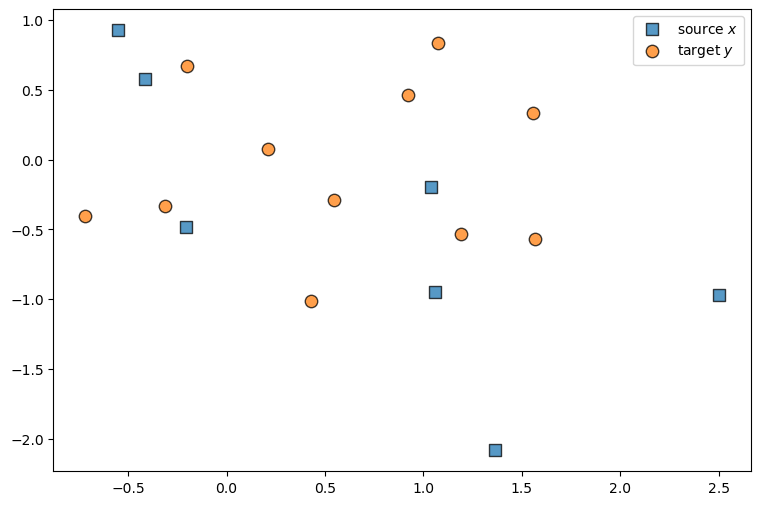

In [3]:
x_args = {
    "s": 80,
    "label": r"source $x$",
    "marker": "s",
    "edgecolor": "k",
    "alpha": 0.75,
}
y_args = {"s": 80, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}
plt.figure(figsize=(9, 6))
plt.scatter(x[:, 0], x[:, 1], **x_args)
plt.scatter(y[:, 0], y[:, 1], **y_args)
plt.legend()
plt.show()

In [5]:
geom = pointcloud.PointCloud(x, y)

In [8]:
solve_fn = jax.jit(sinkhorn.solve)
ot = solve_fn(geom, a=None, b=None)

In [9]:
ot = solve_fn(geom)

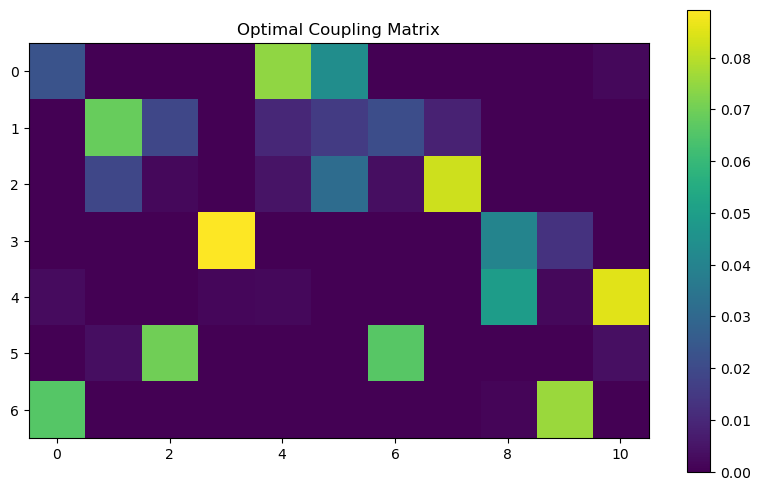

In [10]:
plt.figure(figsize=(10, 6))
plt.imshow(ot.matrix)
plt.colorbar()
plt.title("Optimal Coupling Matrix")
plt.show()

In [11]:
print(
    f"2-Wasserstein: Lower bound = {ot.dual_cost:3f}, upper = {ot.primal_cost:3f}"
)

2-Wasserstein: Lower bound = 0.596925, upper = 1.038265


In [14]:
def reg_ot_cost(x: jnp.ndarray, y: jnp.ndarray) -> float:
    geom = pointcloud.PointCloud(x, y)
    ot = sinkhorn.solve(geom)
    return ot.reg_ot_cost

In [15]:
# value and gradient *function*
r_ot = jax.value_and_grad(reg_ot_cost)
# evaluate it at `(x, y)`.
cost, grad_x = r_ot(x, y)
assert grad_x.shape == x.shape

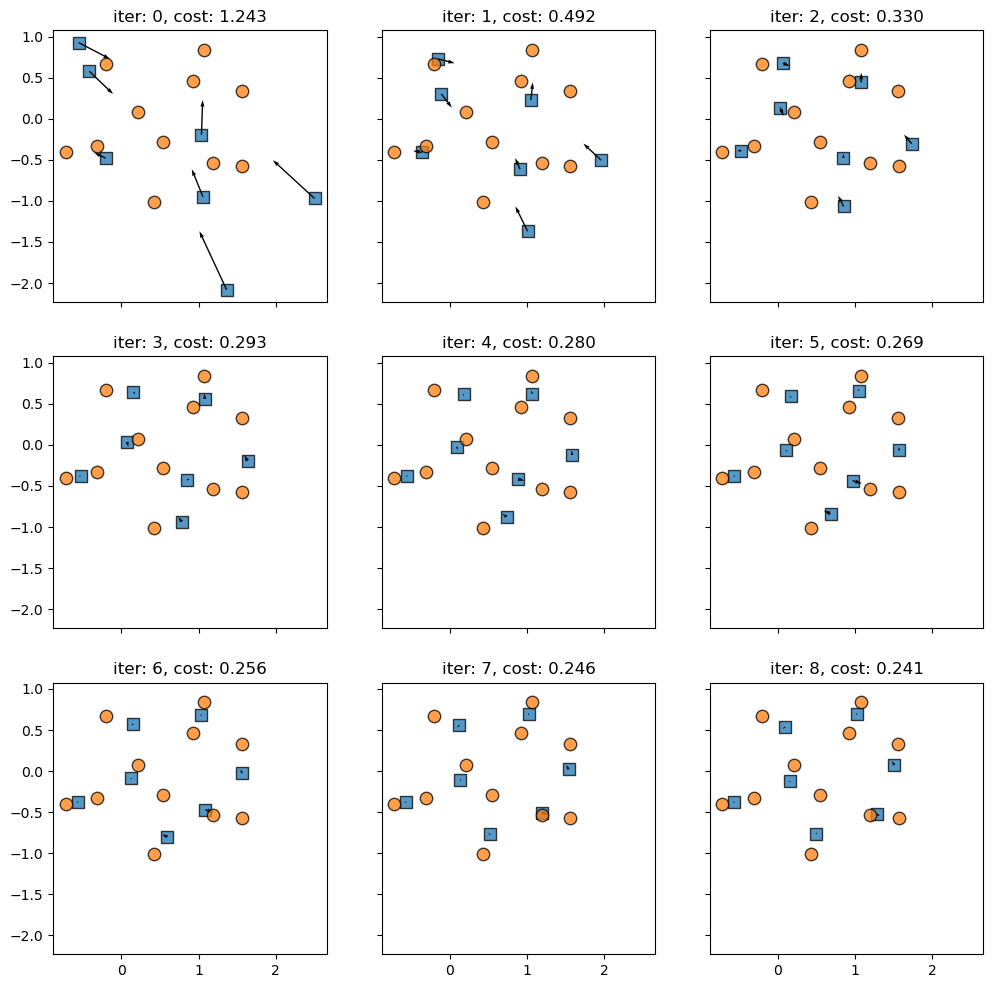

In [17]:
step = 2.0
x = x_old
quiv_args = {"scale": 1, "angles": "xy", "scale_units": "xy", "width": 0.005}
f, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12, 12))
axes = axes.flatten()

for iteration, ax in enumerate(axes):
    cost, grad_x = r_ot(x, y)
    ax.scatter(x[:, 0], x[:, 1], **x_args)
    ax.quiver(
        x[:, 0],
        x[:, 1],
        -step * grad_x[:, 0],
        -step * grad_x[:, 1],
        **quiv_args,
    )
    ax.scatter(y[:, 0], y[:, 1], **y_args)
    ax.set_title(f"iter: {iteration}, cost: {cost:.3f}")
    x -= step * grad_x